<a href="https://colab.research.google.com/github/Kavyakav90/All-UK-House-Price-Prediction/blob/main/uk_houseprice_pr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import shap
import joblib
import os
from flask import Flask, request, jsonify

In [3]:
# Load original dataset for visualization
df= pd.read_csv("UK-HPI-full-file-2024-01 (1).csv")

In [4]:
# Convert 'Date' to DateTime
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

In [5]:
# Select relevant columns
columns_to_keep = [
    'Date', 'RegionName', 'AveragePrice', 'SalesVolume',
    'DetachedPrice', 'SemiDetachedPrice', 'TerracedPrice', 'FlatPrice',
    '1m%Change', '12m%Change', 'NewPrice', 'OldPrice'
]
df = df[columns_to_keep]

In [6]:
# Handling missing values
df.fillna(df.median(numeric_only=True), inplace=True)  # Numeric columns
df.fillna(df.mode().iloc[0], inplace=True)  # Categorical columns

In [7]:
df.isnull().sum()

,0
Date,0
RegionName,0
AveragePrice,0
SalesVolume,0
DetachedPrice,0
SemiDetachedPrice,0
TerracedPrice,0
FlatPrice,0
1m%Change,0
12m%Change,0


In [8]:
df.describe()

,Date,AveragePrice,SalesVolume,DetachedPrice,SemiDetachedPrice,TerracedPrice,FlatPrice,1m%Change,12m%Change,NewPrice,OldPrice
count,39259,3.925900e+04,39259.000000,3.925900e+04,3.925900e+04,3.925900e+04,3.925900e+04,39259.000000,39259.000000,3.925900e+04,3.925900e+04
mean,2009-10-10 14:25:05.142769664,1.751503e+05,367.768741,3.031600e+05,1.938235e+05,1.543593e+05,1.191245e+05,0.515380,6.238939,2.058819e+05,1.739149e+05
min,1968-04-01 00:00:00,3.025671e+03,2.000000,4.064610e+04,2.571306e+04,2.066401e+04,1.621248e+04,-30.297781,-32.175901,3.448924e+04,2.278638e+04
25%,2002-12-01 00:00:00,1.008092e+05,146.000000,1.662512e+05,1.043754e+05,8.365829e+04,6.909641e+04,-0.475177,1.376624,1.286668e+05,1.023460e+05
50%,2010-02-01 00:00:00,1.497007e+05,226.000000,2.391350e+05,1.498946e+05,1.213373e+05,9.827903e+04,0.500000,5.332303,1.856965e+05,1.500398e+05
75%,2017-02-01 00:00:00,2.159247e+05,378.000000,3.467905e+05,2.196606e+05,1.806158e+05,1.406065e+05,1.469108,10.126530,2.524356e+05,2.116904e+05
max,2024-01-01 00:00:00,1.184268e+06,12702.000000,3.707611e+06,3.117125e+06,2.086282e+06,1.102861e+06,31.302591,85.916198,1.253562e+06,1.177562e+06
std,NaN,1.212000e+05,680.433339,2.914805e+05,2.141448e+05,1.523136e+05,1.001157e+05,1.990518,8.838958,1.257517e+05,1.188662e+05


In [9]:
# Selecting top 10 regions with highest average house prices
top_regions = df.groupby('RegionName')['AveragePrice'].mean().nlargest(10).index
df_top_regions = df[df['RegionName'].isin(top_regions)]

In [10]:
top_regions=df_top_regions

In [11]:
top_regions

,Date,RegionName,AveragePrice,SalesVolume,DetachedPrice,SemiDetachedPrice,TerracedPrice,FlatPrice,1m%Change,12m%Change,NewPrice,OldPrice
3853,1995-01-01,Barnet,93284.51832,332.0,2.196147e+05,121186.2434,87984.90108,75149.33076,0.500000,5.332303,89364.32699,93545.36039
3854,1995-02-01,Barnet,93190.16963,327.0,2.165749e+05,121246.3917,88307.04472,75030.41539,-0.101141,5.332303,90040.50642,93334.14071
3855,1995-03-01,Barnet,92247.52435,384.0,2.141044e+05,119999.8953,87514.71085,74258.98070,-1.011529,5.332303,89343.64525,92357.45036
3856,1995-04-01,Barnet,90762.87492,304.0,2.092069e+05,118023.4049,86293.10664,73148.50489,-1.609419,5.332303,88016.01403,90854.14135
3857,1995-05-01,Barnet,90258.00033,393.0,2.087477e+05,117318.1437,85837.74135,72683.66382,-0.556257,5.332303,87379.13058,90371.01031
...,...,...,...,...,...,...,...,...,...,...,...,...
34948,2023-09-01,Ealing,533448.00000,205.0,1.272931e+06,768483.0000,629224.00000,410030.00000,-0.300000,-2.200000,517183.00000,537094.00000
34949,2023-10-01,Ealing,527435.00000,198.0,1.252326e+06,757612.0000,620796.00000,406644.00000,-1.100000,-3.200000,520494.00000,530048.00000
34950,2023-11-01,Ealing,514089.00000,122.0,1.215591e+06,736563.0000,602255.00000,398239.00000,-2.500000,-7.500000,520313.00000,515333.00000
34951,2023-12-01,Ealing,522217.00000,226.0,1.208623e+06,741984.0000,607520.00000,408544.00000,1.600000,-5.600000,185696.47150,150039.75670


In [12]:
#splitting the datat
# Sort the dataset by Date
df_sorted = df.sort_values(by='Date').reset_index(drop=True)

# Define the split point (80% train, 20% test)
split_index = int(len(df_sorted) * 0.8)

# Time-based train/test split
train_set = df_sorted.iloc[:split_index]
test_set = df_sorted.iloc[split_index:]

# Split features and target
X_train = train_set.drop(columns=['AveragePrice'])
y_train = train_set['AveragePrice']
X_test = test_set.drop(columns=['AveragePrice'])
y_test = test_set['AveragePrice']

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")


Train set: (31407, 11), Test set: (7852, 11)


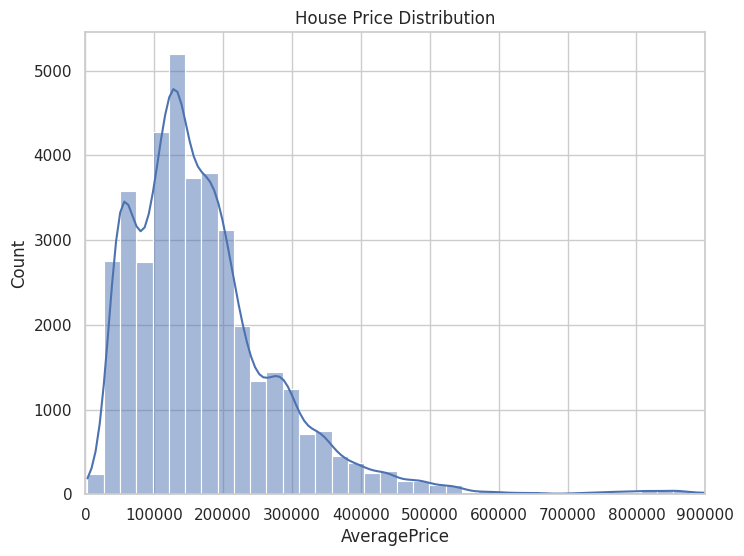

In [13]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.histplot(data=df,x='AveragePrice',bins=50,kde=True)
plt.xlim(0,900000)
plt.title("House Price Distribution")
plt.xlabel("AveragePrice")
plt.ylabel("Count")
plt.show()

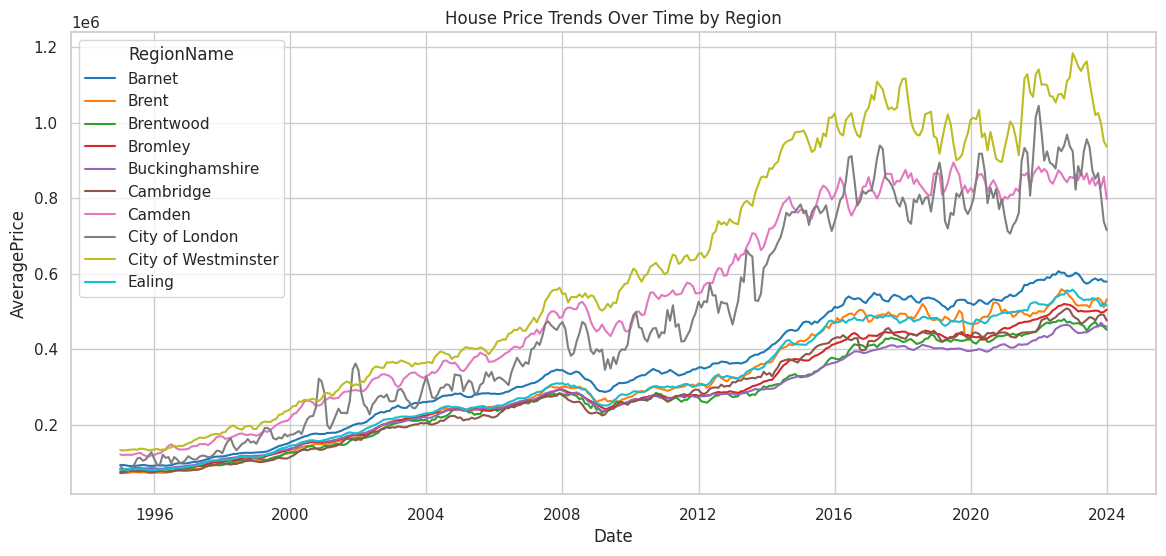

In [14]:
# 2. House Price Trends Over Time by Region
plt.figure(figsize=(14, 6))
sns.lineplot(x='Date', y='AveragePrice', data=top_regions, hue='RegionName', palette='tab10')
plt.title("House Price Trends Over Time by Region")
plt.show()

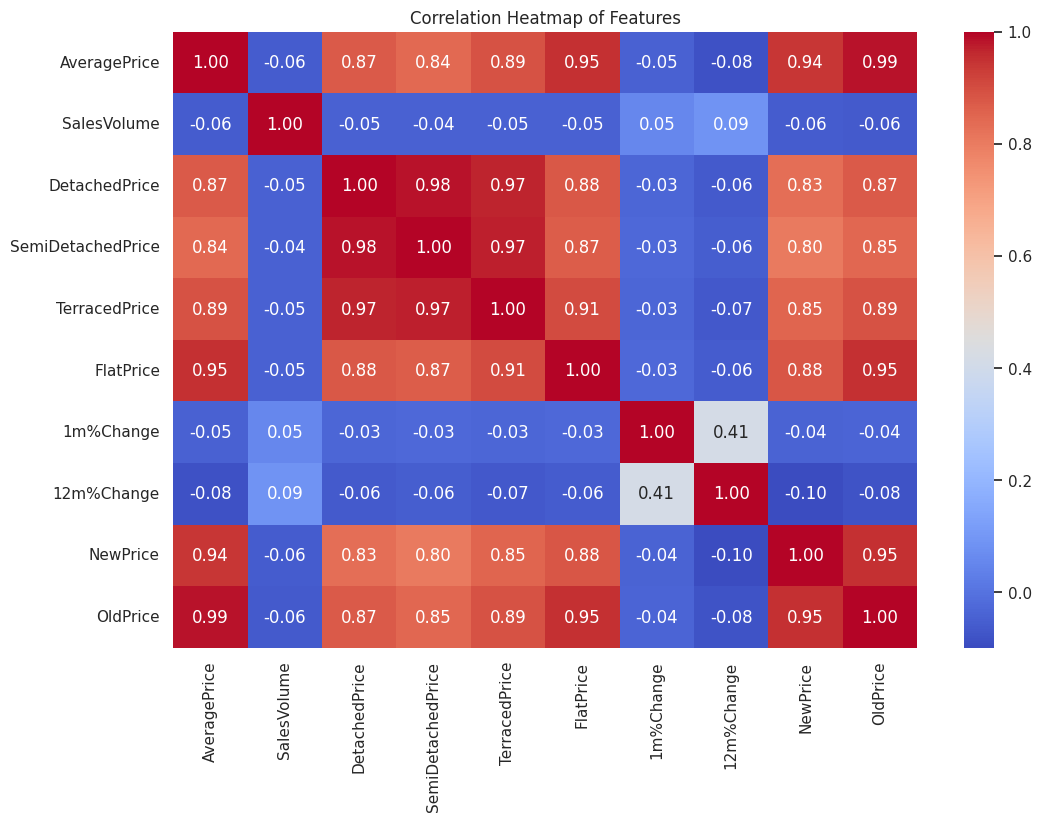

In [15]:
# 3. Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap of Features")
plt.show()

<ipython-input-16-fae52b3f7512>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='RegionName', y='AveragePrice', data=df_top_regions, palette='coolwarm')


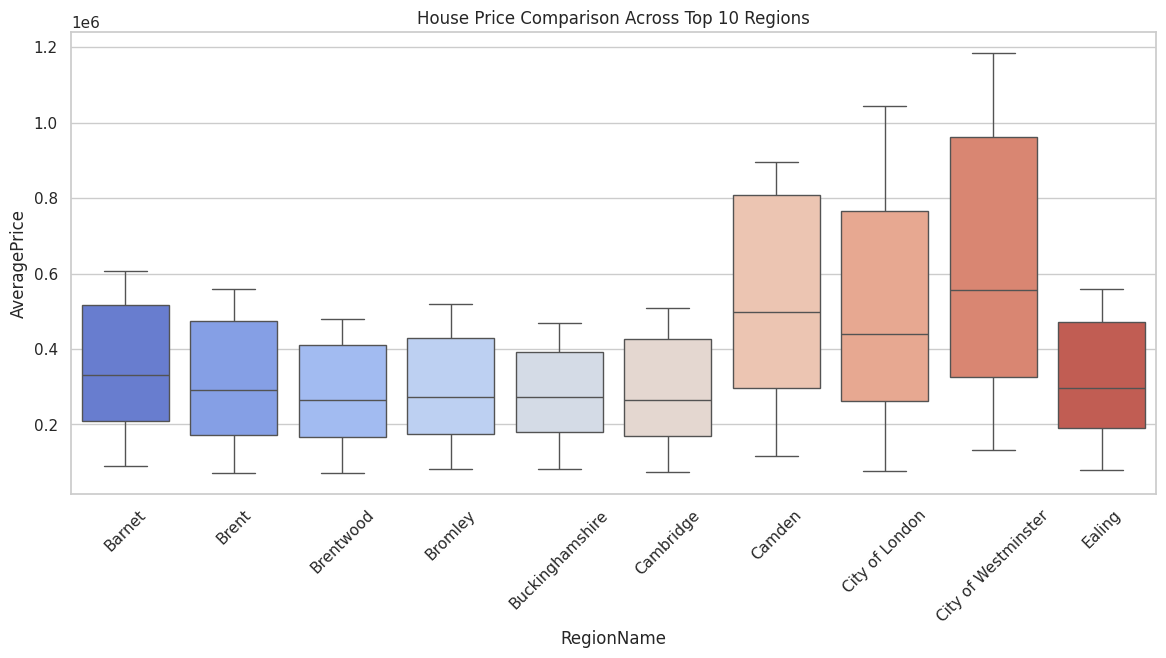

In [16]:
# 4. Boxplot Comparison for Property Types in Top 10 Regions
plt.figure(figsize=(14, 6))
sns.boxplot(x='RegionName', y='AveragePrice', data=df_top_regions, palette='coolwarm')
plt.xticks(rotation=45)
plt.title("House Price Comparison Across Top 10 Regions")
plt.show()

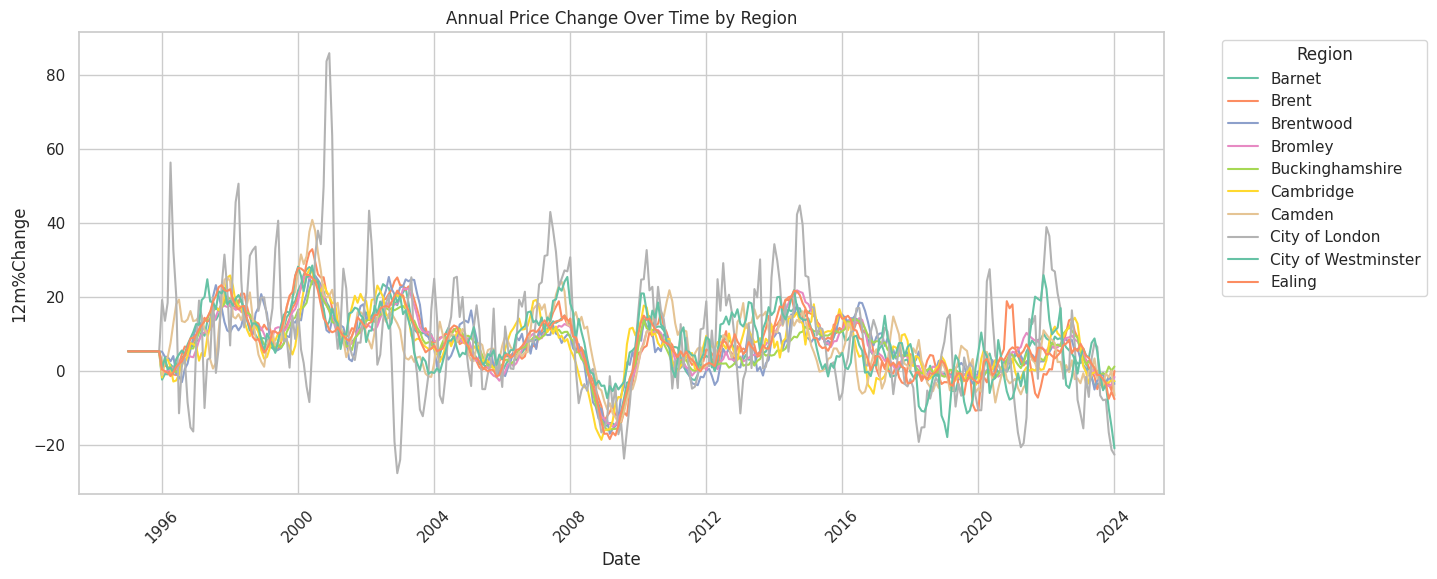

In [17]:
# 6. Annual Price Change Over Time
plt.figure(figsize=(14, 6))
sns.lineplot(x='Date', y='12m%Change', data=top_regions, hue='RegionName', palette='Set2')
plt.title("Annual Price Change Over Time by Region")
plt.xticks(rotation=45)
plt.legend(title="Region", bbox_to_anchor=(1.25,1), loc='upper right')
plt.show()

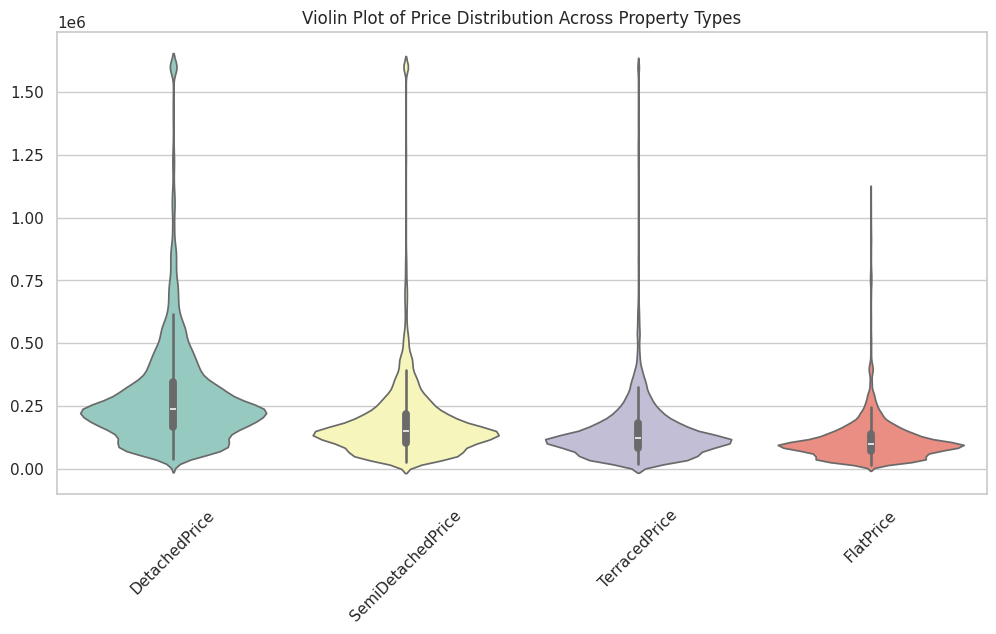

In [18]:
# 7. Violin Plot for Property Type Price Distribution
df_c = df[['DetachedPrice', 'SemiDetachedPrice', 'TerracedPrice', 'FlatPrice']].clip(upper=1.6e6)

plt.figure(figsize=(12, 6))
sns.violinplot(data=df_c, palette='Set3')
plt.title("Violin Plot of Price Distribution Across Property Types")
plt.xticks(rotation=45)
plt.show()


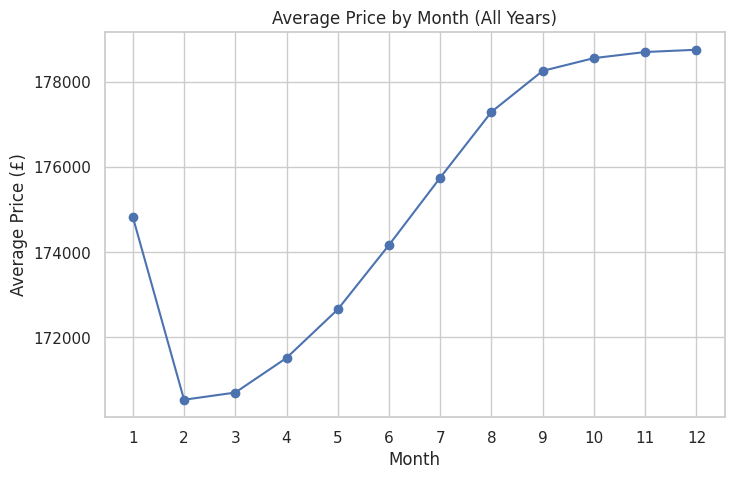

In [19]:
monthly_avg = df.groupby(df['Date'].dt.month)['AveragePrice'].mean()

plt.figure(figsize=(8, 5))
monthly_avg.plot(marker='o')
plt.title('Average Price by Month (All Years)')
plt.xlabel('Month')
plt.ylabel('Average Price (£)')
plt.xticks(np.arange(1, 13))
plt.grid(True)
plt.show()


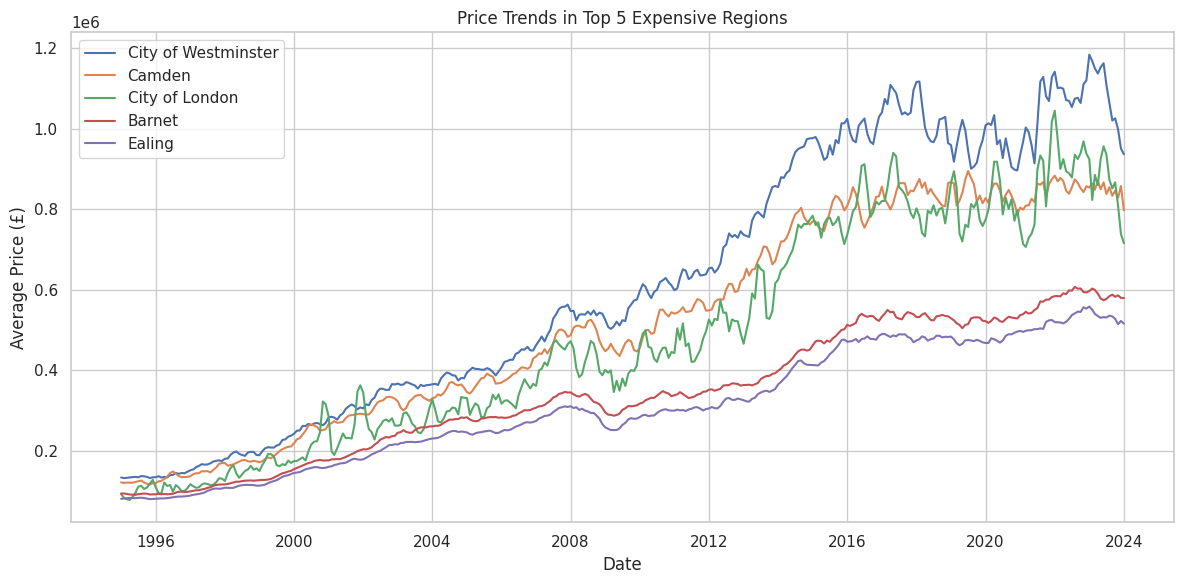

In [20]:
top_5_regions = df.groupby('RegionName')['AveragePrice'].mean().sort_values(ascending=False).head(5).index
plt.figure(figsize=(12, 6))
for region in top_5_regions:
    regional_data = df[df['RegionName'] == region]
    sns.lineplot(x='Date', y='AveragePrice', data=regional_data, label=region)

plt.title('Price Trends in Top 5 Expensive Regions')
plt.xlabel('Date')
plt.ylabel('Average Price (£)')
plt.legend()
plt.tight_layout()
plt.show()


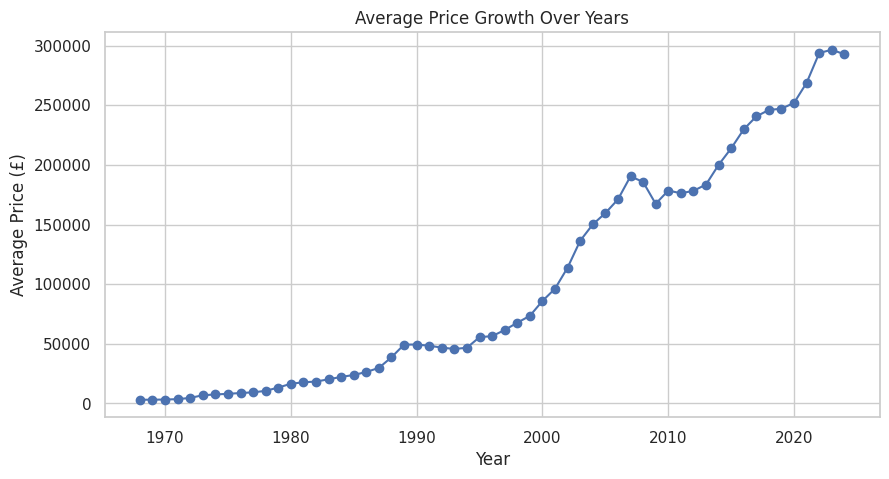

In [21]:
yearly_avg = df.groupby(df['Date'].dt.year)['AveragePrice'].mean()

plt.figure(figsize=(10, 5))
yearly_avg.plot(marker='o')
plt.title("Average Price Growth Over Years")
plt.xlabel("Year")
plt.ylabel("Average Price (£)")
plt.grid(True)
plt.show()


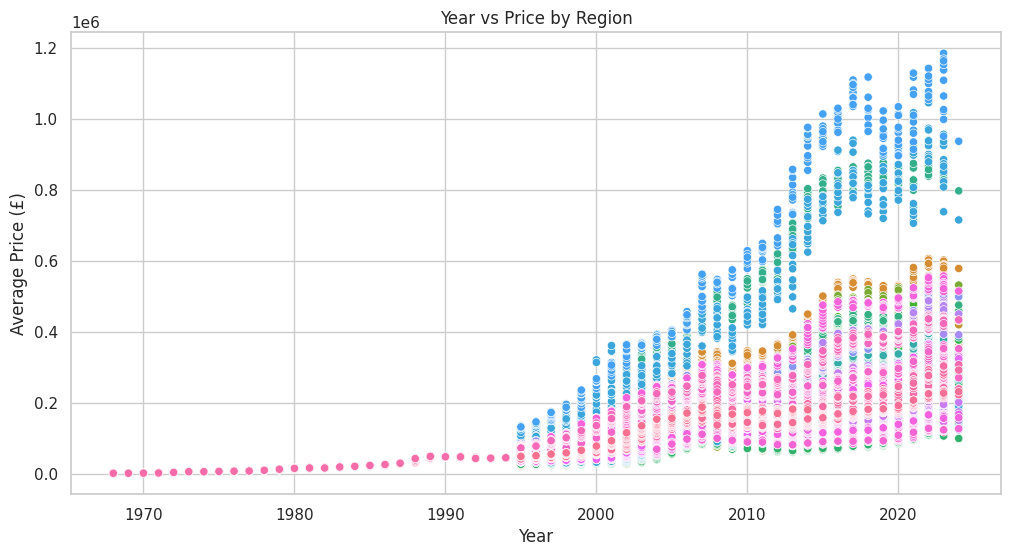

In [22]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x=df['Date'].dt.year, y='AveragePrice', hue='RegionName', legend=False)
plt.title('Year vs Price by Region')
plt.xlabel('Year')
plt.ylabel('Average Price (£)')
plt.show()


<ipython-input-23-31711bbcdd5d>:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


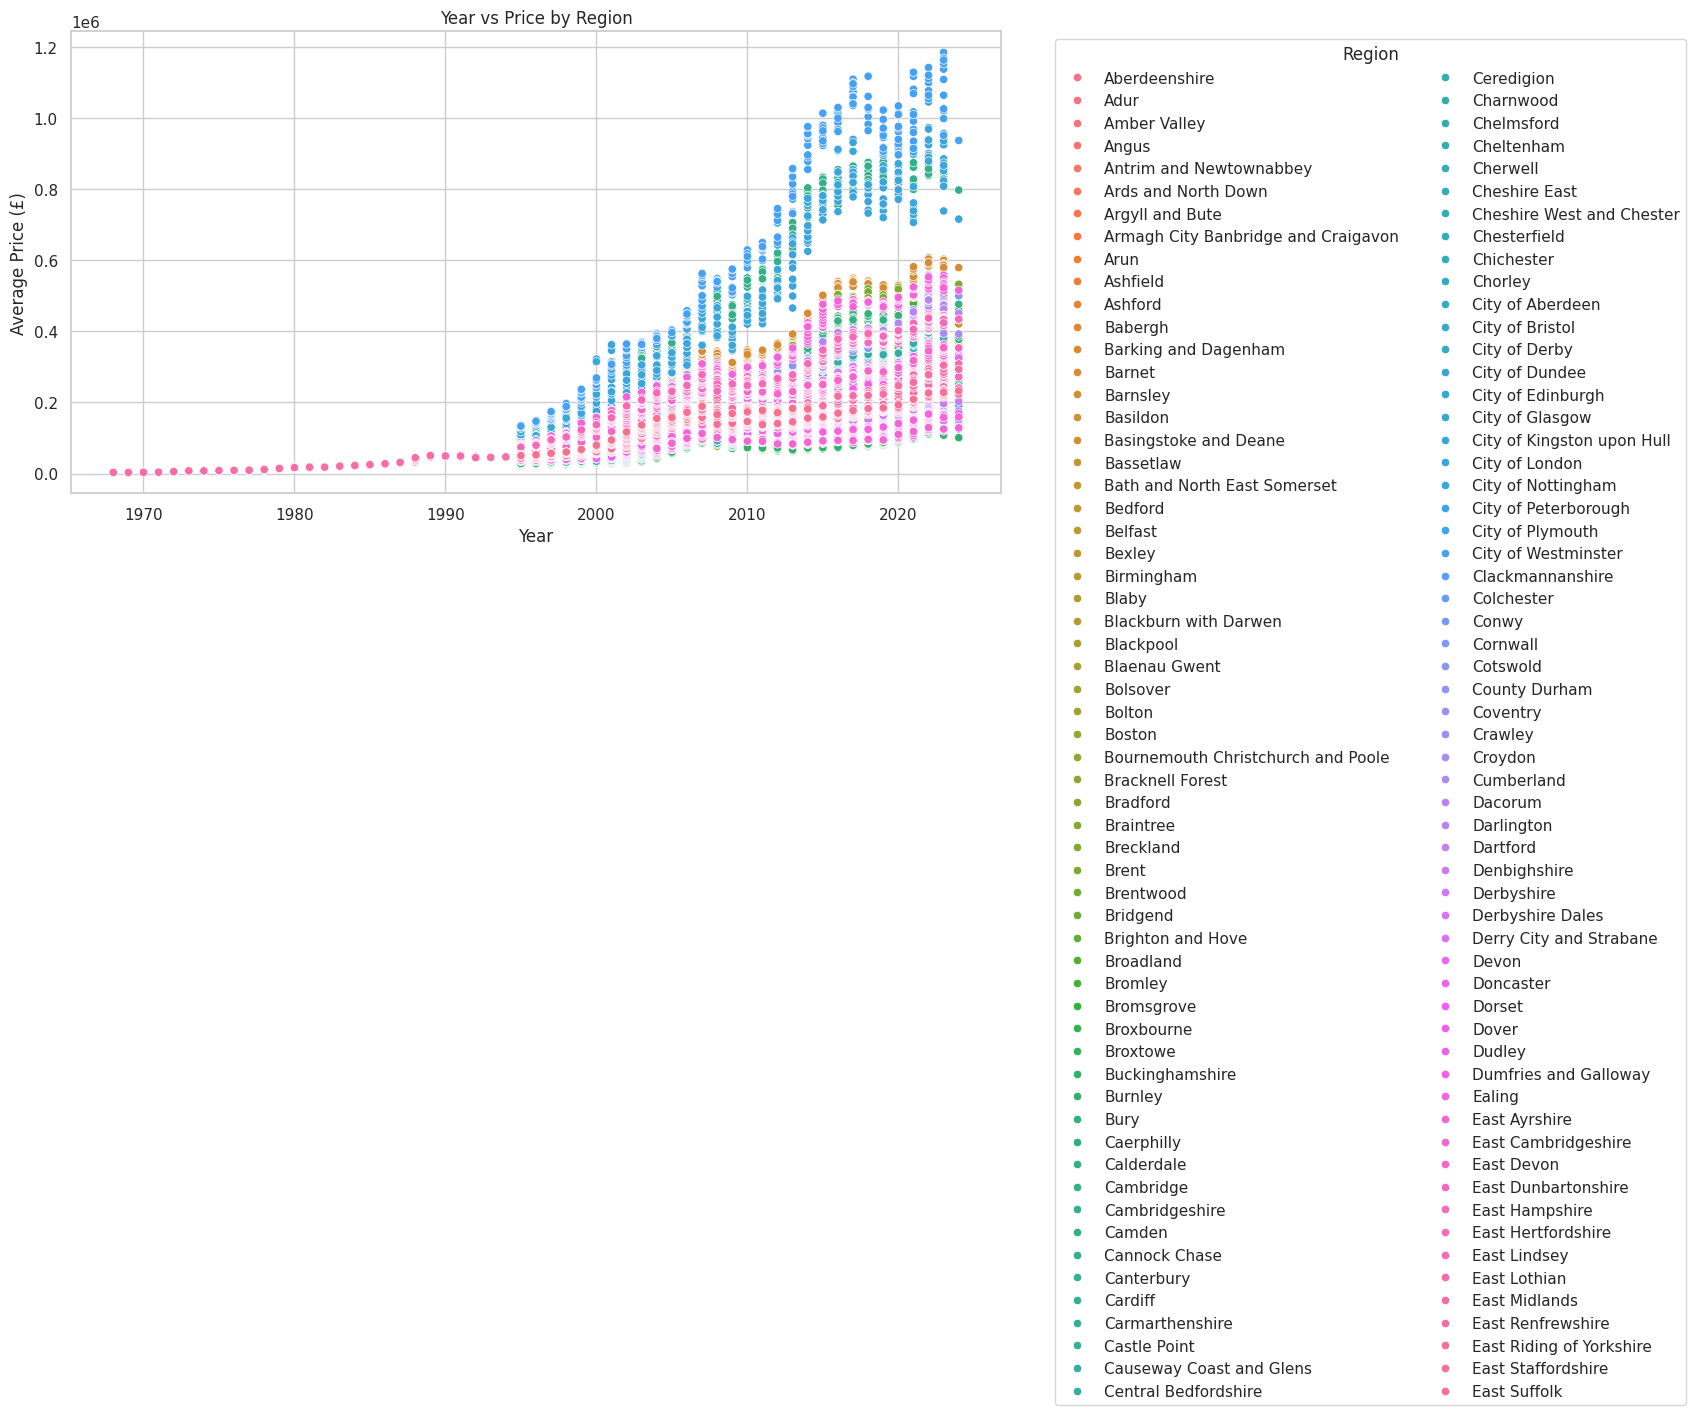

In [23]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df,
    x=df['Date'].dt.year,
    y='AveragePrice',
    hue='RegionName',
    legend='full'
)
plt.title('Year vs Price by Region')
plt.xlabel('Year')
plt.ylabel('Average Price (£)')

# Create the legend outside the plot with multiple columns
plt.legend(
    title="Region",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    ncol=2  # Display legend in 2 columns
)
plt.tight_layout()
plt.show()


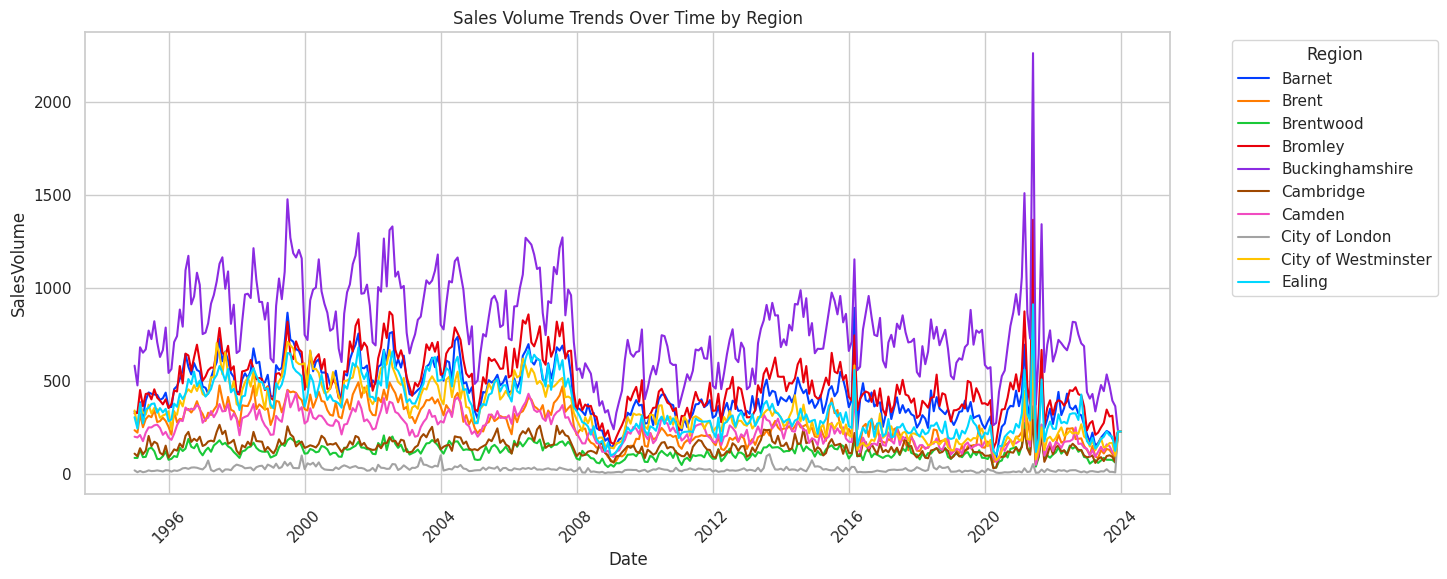

In [24]:
# 8. Sales Volume Trends Over Time
plt.figure(figsize=(14, 6))
sns.lineplot(x='Date', y='SalesVolume', data=top_regions, hue='RegionName', palette='bright')
plt.title("Sales Volume Trends Over Time by Region")
plt.xticks(rotation=45)
plt.legend(
    title="Region",
    bbox_to_anchor=(1.05, 1),
    loc='upper left')
plt.show()

In [25]:
# Scaling numeric features
scaler = StandardScaler()
numeric_cols = ['AveragePrice', 'SalesVolume', 'DetachedPrice', 'SemiDetachedPrice',
                'TerracedPrice', 'FlatPrice', '1m%Change', '12m%Change', 'NewPrice', 'OldPrice']
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])


In [26]:
# Encoding categorical variables (RegionName)
le = LabelEncoder()
df['RegionName'] = le.fit_transform(df['RegionName'])

In [27]:
X = df.drop(columns=['AveragePrice', 'Date'])
y = df['AveragePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "ElasticNet": ElasticNet(alpha=0.1),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=5, min_samples_leaf=2, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostRegressor(n_estimators=50, random_state=42),
    "Support Vector Regression": SVR(kernel='rbf'),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}

results = {}
if not os.path.exists("saved_models"):
    os.makedirs("saved_models")

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    try:
        cross_val = cross_val_score(model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1).mean()
    except:
        cross_val = None

    results[name] = {
        "R2 Score": r2_score(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "MAE": mean_absolute_error(y_test, y_pred),
        "Cross-Val R2": cross_val
    }

    joblib.dump(model, f"saved_models/{name.replace(' ', '_').lower()}.pkl")


Training Linear Regression...
Training Ridge Regression...
Training Lasso Regression...
Training ElasticNet...
Training Decision Tree...
Training Random Forest...
Training Gradient Boosting...
Training AdaBoost...
Training Support Vector Regression...
Training XGBoost...


,R2 Score,RMSE,MAE,Cross-Val R2
Decision Tree,0.999,0.028,0.009,0.998
XGBoost,0.998,0.039,0.014,0.997
Random Forest,0.998,0.041,0.009,0.998
Gradient Boosting,0.996,0.067,0.031,0.995
Linear Regression,0.978,0.149,0.058,0.974
Ridge Regression,0.978,0.149,0.058,0.974
Support Vector Regression,0.976,0.155,0.068,0.972
ElasticNet,0.968,0.177,0.100,0.965
Lasso Regression,0.967,0.182,0.098,0.962
AdaBoost,0.951,0.222,0.168,0.955


<ipython-input-29-e07e6d55baab>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df.reset_index(), x="R2 Score", y="index", palette="coolwarm")


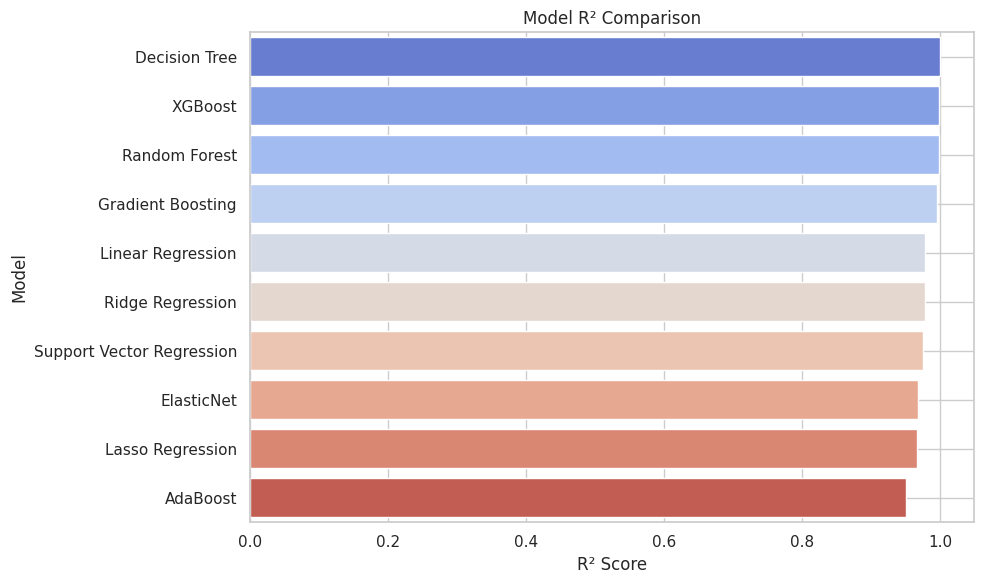

In [29]:
results_df = pd.DataFrame(results).T.sort_values("R2 Score", ascending=False)
display(results_df.round(3))

# Visual Comparison
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df.reset_index(), x="R2 Score", y="index", palette="coolwarm")
plt.title("Model R² Comparison")
plt.xlabel("R² Score")
plt.ylabel("Model")
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
rf = RandomForestRegressor()

rf.fit(X_train, y_train)
df.drop(columns=['Date'],inplace=True)
r2_train = rf.score(X_train, y_train)
r2_test = rf.score(X_test, y_test)

print(f"Train R²: {r2_train:.4f} | Test R²: {r2_test:.4f}")

Train R²: 0.9998 | Test R²: 0.9993


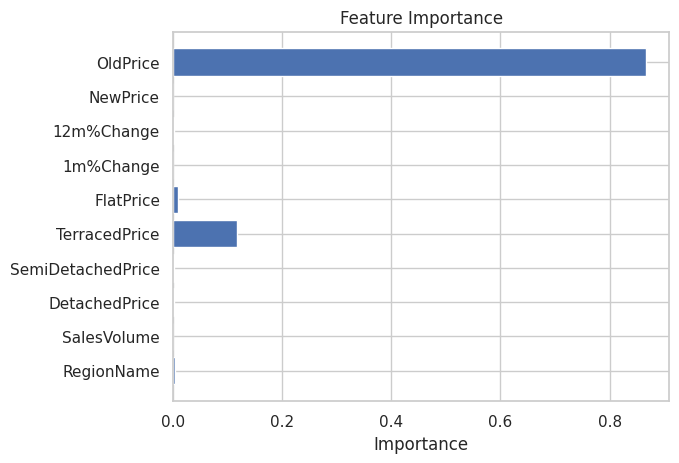

In [31]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

importances = model.feature_importances_
features = X_train.columns

plt.barh(features, importances)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.show()


In [32]:
df.corr()['AveragePrice'].sort_values(ascending=False)

,AveragePrice
AveragePrice,1.000000
OldPrice,0.985485
FlatPrice,0.949694
NewPrice,0.942541
TerracedPrice,0.889867
DetachedPrice,0.873062
SemiDetachedPrice,0.844779
RegionName,0.008760
1m%Change,-0.047110
SalesVolume,-0.058730


In [33]:
#Drop Highly Correlated Features
# Create a reduced dataset without dominant features
drop_cols = ['OldPrice', 'FlatPrice', 'NewPrice']  # You can try combinations
df_reduced = df.drop(columns=drop_cols)

# Re-define features and target
X = df_reduced.drop(columns=['AveragePrice'])
y = df_reduced['AveragePrice']

# Use time-based split again
df_sorted = df_reduced.sort_values(by='Date').reset_index(drop=True)
split_index = int(len(df_sorted) * 0.8)

train_set = df_sorted.iloc[:split_index]
test_set = df_sorted.iloc[split_index:]

X_train = train_set.drop(columns=['AveragePrice'])
y_train = train_set['AveragePrice']
X_test = test_set.drop(columns=['AveragePrice'])
y_test = test_set['AveragePrice']


KeyError: 'Date'